In [1]:
# Tony loves cars

from carabao.neurotron import Neurotron,Monitor,Record,toy,cat

#===========================================================================
# class Cells
#===========================================================================

class Cells:
    def __init__(self,n,par,sizes,verbose=0):
        self.verbose = verbose
        self.cells = []
        for k in range(n):
            cell = Neurotron(k,par,sizes,'cell-%g'%k)
            self.cells.append(cell)
        self.record = Record(self)
        
    def __call__(self,y,log=None):
        if log is not None:
            if self.verbose > 0: print("\n"+log)
            log = None if self.verbose == 0 else log
        for k in range(len(self.cells)):
            y = self.cells[k](y,log)

        self.record(self)

        if (self.verbose > 0):
            self.log(y,log)
        return y

    def __getitem__(self,k):
        return self.cells[k]

    def range(self):
        return range(len(self.cells))
        
    def plot(self,j,tag=''):   # plot cell column at monitor location (*,j)
        for k in range(len(self.cells)):
            mon(self.cells[k],k,j)
        mon.xlabel(j,tag,8)

    def log(self,y,tag=None):
        self.record.log(self,y,tag)

    def iterate(self,k,y,tag,log=None):
       head = 'iteration' if log is None else log + ' - iteration'
       y = self(y,'%s %g (%s)'%(head,k,tag))
       self.plot(k,tag)
       return y
    
    def iteration(self,y,tag=None):
        self.record.clear()
        tags = ['decode','settle','excite','react','observe','burst',
                'predict','learn','relax1','relax2']
        for k in range(len(tags)): 
            y = self.iterate(k,y,tags[k],log=tag)
        return y
            
#===========================================================================
# helper: check cell's movie with given pattern
#===========================================================================

def check(cells,pattern):
    """
    check(): check recorder pattern of a network of cells against a given
             pattern and raise exception if check fails.
    >>> par,token = toy('sarah')
    >>> cells = Cells(3,par,[3,10])
    >>> y = cells.iteration([0,0,0]+token['Sarah'])
    >>> check(cells,'|U,U,QB,QBY,DY,D--|---D,XD,X,X,X|---D,D---|')
    """
    p = cells.record.pattern()
    if p != pattern:
        print('expected: ',pattern)
        print('got:      ',p)
        raise Exception('pattern check failed')



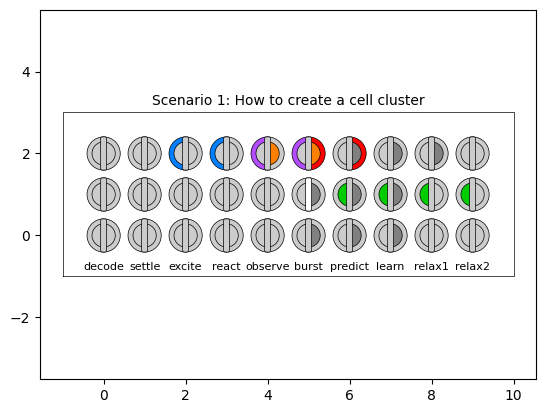

In [2]:
mon = Monitor(3,10,'Scenario 1: How to create a cell cluster')

#===========================================================================
# How to create a cells cluster 
#===========================================================================

par,token = toy('tony')
cells = Cells(3,par,[3,10],verbose=0)
y = cells.iteration([0,0,0]+token['Tony'])
check(cells,'|--U,U,UQB,UQBY,DY,D,D-|-----DS,XD,XD,X,X|-----D,D,D--|')

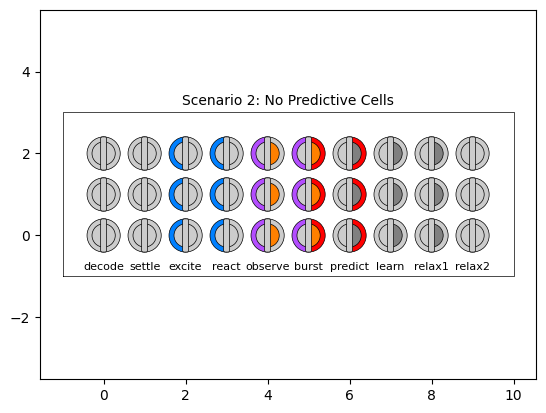

In [3]:
#===========================================================================
# Secario 2: No predictive cells 
#===========================================================================
par,token = toy('tony');  epar,dpar,ppar,dyn = par
epar.p[2] = epar.p[1] = epar.p[0]             # overwrite => all the same
ppar.P[2][0] = ppar.P[1][0] = ppar.P[0][0]    # overwrite => all the same

y,sizes = cat(c:=[0,0,0],token['Tony'])
cells = Cells(3,par,sizes,verbose=0)

mon = Monitor(3,10,'Scenario 2: No Predictive Cells')
y = cells.iteration(y)
check(cells,'|--U,U,UQB,UQBY,DY,D,D-|--U,U,UQB,UQDBY,DY,D,D-|--U,U,UQB,UQDBY,DY,D,D-|')

=> learning: L: #[0 0 0; 0 0 0]
             P: #[0.3 0.4 0.1; 0.3 0.4 0.1]
=> learning: L: #[0 0 0; 0 0 0]
             P: #[0.3 0.4 0.1; 0.3 0.4 0.1]


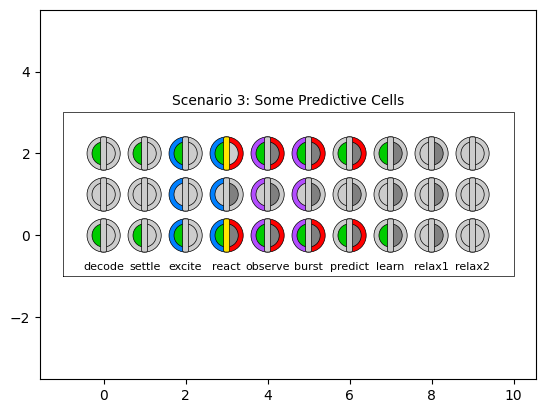

In [4]:
#===========================================================================
# Secario 3: some predictive cells 
#===========================================================================
par,token = toy('tony');  epar,dpar,ppar,dyn = par
epar.p[2] = epar.p[1] = epar.p[0]             # overwrite => all the same
ppar.P[2][0] = ppar.P[1][0] = ppar.P[0][0]    # overwrite => all the same

y,sizes = cat(c:=[0,0,0],token['Tony'])
cells = Cells(3,par,sizes,verbose=0)
cells[0].x.set(1)
cells[2].x.set(1)

mon = Monitor(3,10,'Scenario 3: Some Predictive Cells')
y = cells.iteration(y)
check(cells,'|X,X,UX,UXLY,UQXDY,UQXDY,XDY,XD,D-|--U,UD,UQD,UQD,D,D,D-|X,X,UX,UXLDY,UQXDY,UQXDY,XDY,XD,D-|')


=> learning: L: #[0.1 -0.1 -0.1; 0 -0 -0]
             P: #[0.6 0.1 0.2; 0.3 0.4 0.1]
=> learning: L: #[-0.1 0.1 -0.1; -0 0 -0]
             P: #[0 0.8 0.2; 0.3 0.4 0.1]


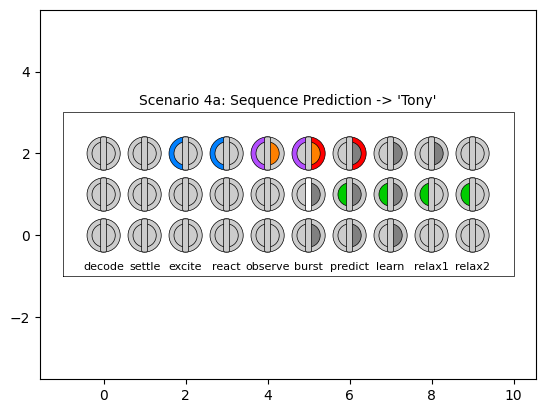

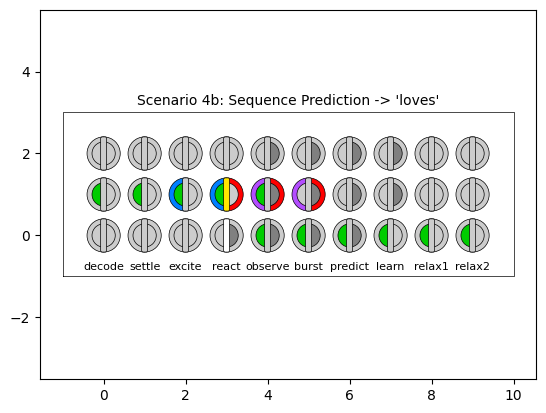

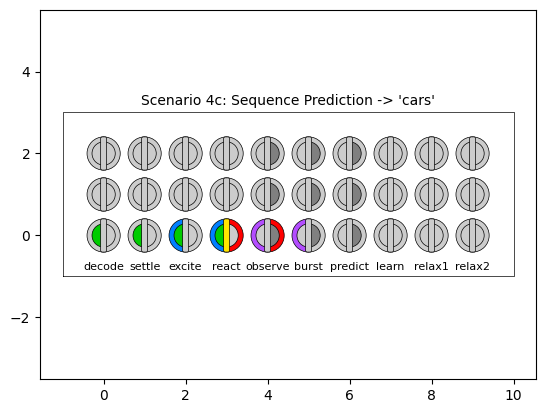

In [5]:
#===========================================================================
# Secario 4: Sequence Prediction -> 'Sarah'
#===========================================================================
par,token = toy('tony')
#par[0].p[2] = par[0].p[1] = par[0].p[0] # overwrite => all the same

mon = Monitor(3,10,"Scenario 4a: Sequence Prediction -> 'Tony'")
y,sizes = cat(c:=[0,0,0],token['Tony'])
cells = Cells(3,par,sizes,verbose=0)
y = cells.iteration(y,'Tony')
check(cells,'|--U,U,UQB,UQBY,DY,D,D-|-----DS,XD,XD,X,X|-----D,D,D--|')

mon = Monitor(3,10,"Scenario 4b: Sequence Prediction -> 'loves'")
y,sizes = cat(c:=y[:3],token['loves'])
y = cells.iteration(y,'loves')
check(cells,'|----D,D,D,D--|X,X,UX,UXLY,UQXDY,UQDY,D,D--|---DS,XD,XD,XD,X,X,X|')

mon = Monitor(3,10,"Scenario 4c: Sequence Prediction -> 'cars'")
y,sizes = cat(c:=y[:3],token['cars'])
y = cells.iteration(y,'cars')
check(cells,'|----D,D,D---|----D,D,D---|X,X,UX,UXLY,UQDY,UQD,D---|')